In [1]:
from google.colab import files
files.upload()

!mkdir ~/.kaggle
!cp kaggle.json ~/.kaggle/
!chmod 600 ~/.kaggle/kaggle.json
!kaggle datasets download -d wobotintelligence/face-mask-detection-dataset
!rm kaggle.json

Saving kaggle.json to kaggle.json
mkdir: cannot create directory ‘/root/.kaggle’: File exists
face-mask-detection-dataset.zip: Skipping, found more recently modified local copy (use --force to force download)


In [2]:
!rm -rf Medical \mask
!unzip face-mask-detection-dataset.zip

Archive:  face-mask-detection-dataset.zip
replace Medical mask/Medical mask/Medical Mask/annotations/1801.jpg.json? [y]es, [n]o, [A]ll, [N]one, [r]ename: N


In [3]:
!rm -rf sample_data

In [4]:
!pip install mtcnn

     |████████████████████████████████| 2.3MB 5.3MB/s 


# Basic Imports

In [4]:
import os
import csv
import cv2
import json
import random
import pprint as pp
import matplotlib.pyplot as plt

# Preprocessing

In [5]:
BASE_DIR = 'Medical mask/Medical mask/Medical Mask'
IMAGE_DIR = os.path.join(BASE_DIR, 'images')
ANNOTATIONS_DIR = os.path.join(BASE_DIR, 'annotations')

In [6]:
for file in os.listdir(ANNOTATIONS_DIR):
  with open(os.path.join(ANNOTATIONS_DIR, file), 'r') as f:
    data = json.load(f)
    pp.pprint(data)
    break

{'Annotations': [{'Attributes': {},
                  'BoundingBox': [154, 178, 432, 544],
                  'Confidence': 1,
                  'ID': 329330485172403456,
                  'classname': 'face_with_mask',
                  'isProtected': False},
                 {'Attributes': {},
                  'BoundingBox': [171, 340, 429, 541],
                  'Confidence': 1,
                  'ID': 411605424488487232,
                  'classname': 'mask_colorful',
                  'isProtected': False}],
 'FileName': '4615.png',
 'NumOfAnno': 2}


In [7]:
faces_with_mask = []
faces_without_mask = []

with open('train.csv', 'r') as f:
  data = list(csv.reader(f))
  
  faces_with_mask = list(filter(lambda x: x[5] == 'face_with_mask', data[1:]))
  faces_without_mask = list(filter(lambda x: x[5] == 'face_no_mask', data[1:]))

random.shuffle(faces_with_mask)
random.shuffle(faces_without_mask)

print(len(faces_with_mask), len(faces_without_mask))

4180 1569


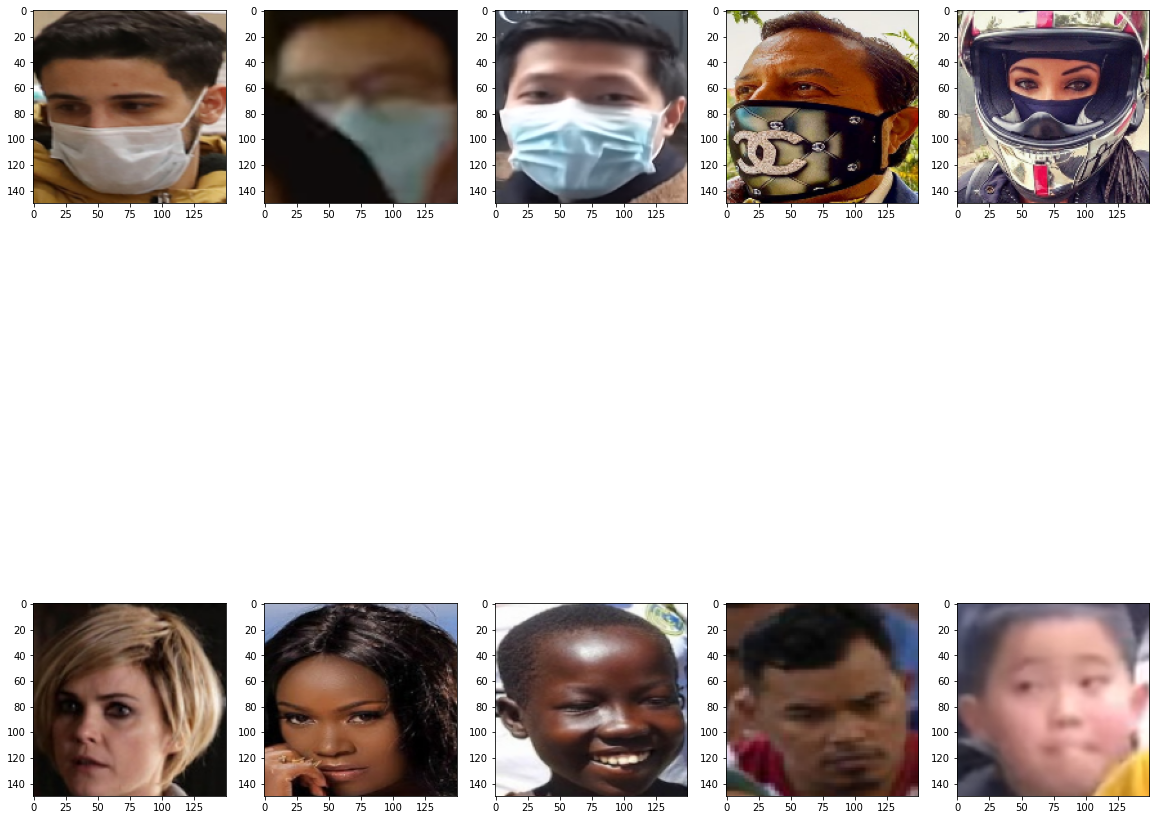

In [8]:
# Viewing data

fig, ax = plt.subplots(2, 5, figsize=(20, 20))

for i, face in enumerate(faces_with_mask[:5]):
  image = cv2.cvtColor(cv2.imread(os.path.join(IMAGE_DIR, face[0])), cv2.COLOR_BGR2RGB)
  start = int(face[1]), int(face[2])
  end = int(face[3]), int(face[4])
  image = image[start[1]:end[1], start[0]:end[0]]
  image = cv2.resize(image, (150, 150))
  ax[0, i].imshow(image)

for i, face in enumerate(faces_without_mask[:5]):
  image = cv2.cvtColor(cv2.imread(os.path.join(IMAGE_DIR, face[0])), cv2.COLOR_BGR2RGB)
  start = int(face[1]), int(face[2])
  end = int(face[3]), int(face[4])
  image = image[start[1]:end[1], start[0]:end[0]]
  image = cv2.resize(image, (150, 150))
  ax[1, i].imshow(image)
fig.show()

In [9]:
X = []
y = []

for i, cat in enumerate((faces_without_mask, faces_with_mask)):
  for f in cat:
    image = cv2.cvtColor(cv2.imread(os.path.join(IMAGE_DIR, f[0])), cv2.COLOR_BGR2RGB)
    start = int(f[1]), int(f[2])
    end = int(f[3]), int(f[4])
    image = image[start[1]:end[1], start[0]:end[0]]
    image = cv2.resize(image, (150, 150))
    X.append(image)
    y.append(i)

print(len(X))
print(len(y))

5749
5749


4311 1438


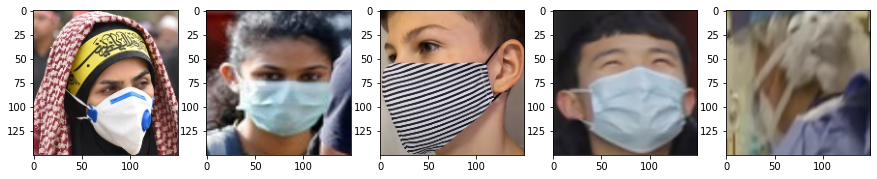

In [10]:
# Splitting the data for training and testing
import numpy as np
from sklearn.model_selection import train_test_split
from tensorflow.keras.applications.vgg19 import preprocess_input


X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.25, random_state=0)


print(len(X_train), len(X_test))

# Viewing training data
fig, ax = plt.subplots(1, 5, figsize=(15, 15))

for i, img in enumerate(X_train[:5]):
  ax[i].imshow(img)
fig.show()

X_train = np.array(X_train, dtype='float32')
y_train = np.array(y_train)
X_test = np.array(X_test, dtype='float32')
y_test = np.array(y_test)

# Creating model architecture

In [14]:
from tensorflow.keras.models import Model
from tensorflow.keras.applications.inception_v3 import InceptionV3
from tensorflow.keras.applications import VGG16,VGG19
from tensorflow.keras.applications import ResNet50,MobileNet,MobileNetV2
from tensorflow.keras.layers import Dense, Flatten, Input, Dropout
from tensorflow.keras.optimizers import Adam


base_model = ResNet50(weights='imagenet', include_top=False, input_tensor=Input(shape=(150, 150, 3)), pooling='avg')

for layer in base_model.layers:
  layer.trainable = False

new_model = base_model.output
new_model = Flatten()(new_model)
new_model = Dense(1024, activation='relu')(new_model)
new_model = Dropout(0.25)(new_model)
new_model = Dense(1024, activation='relu')(new_model)
new_model = Dropout(0.25)(new_model)
new_model = Dense(1, activation='sigmoid')(new_model)

model = Model(inputs=base_model.input, outputs=new_model)
opt = Adam(lr=1e-4)
model.compile(loss='binary_crossentropy' ,optimizer=opt, metrics=['accuracy'])
model.summary()

Model: "model_1"
__________________________________________________________________________________________________
Layer (type)                    Output Shape         Param #     Connected to                     
input_2 (InputLayer)            [(None, 150, 150, 3) 0                                            
__________________________________________________________________________________________________
conv1_pad (ZeroPadding2D)       (None, 156, 156, 3)  0           input_2[0][0]                    
__________________________________________________________________________________________________
conv1_conv (Conv2D)             (None, 75, 75, 64)   9472        conv1_pad[0][0]                  
__________________________________________________________________________________________________
conv1_bn (BatchNormalization)   (None, 75, 75, 64)   256         conv1_conv[0][0]                 
____________________________________________________________________________________________

# Training

In [15]:
history = model.fit(X_train, y_train, epochs=10, validation_split=0.15)

Epoch 1/10
115/115 [==============================] - 8s 69ms/step - loss: 0.1648 - accuracy: 0.9364 - val_loss: 0.1103 - val_accuracy: 0.9567
Epoch 2/10
115/115 [==============================] - 7s 61ms/step - loss: 0.0909 - accuracy: 0.9667 - val_loss: 0.0899 - val_accuracy: 0.9706
Epoch 3/10
115/115 [==============================] - 7s 61ms/step - loss: 0.0651 - accuracy: 0.9754 - val_loss: 0.0766 - val_accuracy: 0.9706
Epoch 4/10
115/115 [==============================] - 7s 62ms/step - loss: 0.0444 - accuracy: 0.9847 - val_loss: 0.0865 - val_accuracy: 0.9706
Epoch 5/10
115/115 [==============================] - 7s 62ms/step - loss: 0.0308 - accuracy: 0.9894 - val_loss: 0.0796 - val_accuracy: 0.9784
Epoch 6/10
115/115 [==============================] - 7s 61ms/step - loss: 0.0202 - accuracy: 0.9937 - val_loss: 0.0943 - val_accuracy: 0.9799
Epoch 7/10
115/115 [==============================] - 7s 61ms/step - loss: 0.0090 - accuracy: 0.9986 - val_loss: 0.0820 - val_accuracy: 0.9753

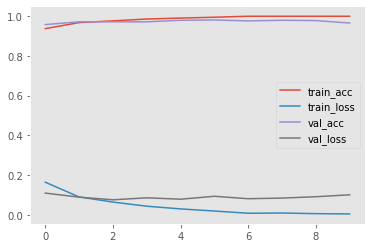

In [17]:
plt.style.use("ggplot")
plt.figure()
plt.plot(history.history['accuracy'], label='train_acc')
plt.plot(history.history['loss'], label='train_loss')
plt.plot(history.history['val_accuracy'], label='val_acc')
plt.plot(history.history['val_loss'], label='val_loss')
plt.grid()
plt.legend()
plt.show()

In [16]:
loss, acc = model.evaluate(X_test, y_test)
print(loss)
print(acc)

45/45 [==============================] - 2s 50ms/step - loss: 0.1058 - accuracy: 0.9680
0.10581076890230179
0.9680111408233643


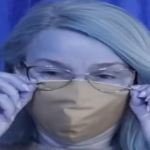

Mask


In [54]:
from google.colab.patches import cv2_imshow

image = random.choice(X_test)
cv2_imshow(image)

from tensorflow.keras.preprocessing.image import img_to_array
predictions = model.predict(image.reshape(-1, 150, 150, 3))
pred = "Mask" if predictions[0][0] >0.5 else "Not Mask"
print(pred)

In [52]:
model.save('model.h5')

In [84]:
y_pred = model.predict(X_test)
for i in y_pred:
  if i[0]<0.5:
    i[0] = 0
  else:
    i[0] = 1
print(y_pred)

[[1.]
 [1.]
 [1.]
 ...
 [0.]
 [0.]
 [0.]]


In [88]:
#Accuracy Score
from sklearn.metrics import confusion_matrix, roc_curve, accuracy_score
print(accuracy_score(y_test, y_pred))

0.9680111265646731


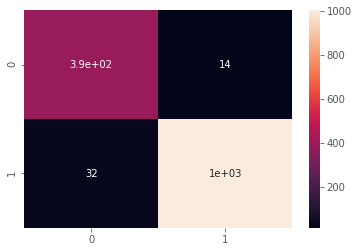

In [89]:
#Confusion Metrics
import seaborn as sns
cm = confusion_matrix(y_test, y_pred)
sns.heatmap(cm, annot=True)